In [1]:
# Input data
import scipy.io as spio
import numpy as np
from utilities import *
from sklearn.model_selection import train_test_split

In [3]:
new_executive = spio.loadmat(file_name='../data/bci_EEG_data-dl_proj/new_EEG_data/new_executive.mat')
print(new_executive.keys())
new_executive_data = new_executive['new_executive']
print(new_executive_data.shape, new_executive_data.dtype)

new_executive_data_transposed = new_executive_data.transpose(2, 0, 1)
print(new_executive_data_transposed.shape)

dict_keys(['__header__', '__version__', '__globals__', 'new_executive'])
(3072, 13, 920) float64
(920, 3072, 13)


In [4]:
# Output data: class labels
new_executive_label = spio.loadmat(file_name=
                                   '../data/bci_EEG_data-dl_proj/new_EEG_data/new_executive_label.mat')
print(new_executive_label.keys())
new_executive_label_all = new_executive_label['new_executive_label']
print(new_executive_label_all.shape, new_executive_label_all.dtype, 
      new_executive_label_all.max(axis=0))

print(np.mean(new_executive_label_all==1), np.mean(new_executive_label_all==2))

dict_keys(['__header__', '__version__', '__globals__', 'new_executive_label'])
(920, 1) uint16 [2]
0.5 0.5


In [5]:
# X_train_norm, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, stratify = labels_train, random_state = 123)
X_train, X_valid, Y_train, Y_valid = train_test_split(new_executive_data_transposed,
                                                      new_executive_label_all,
                                                      stratify = new_executive_label_all,
                                                      random_state = 123,
                                                      test_size=0.10)
print(X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape)
print(X_train.dtype, X_valid.dtype, Y_train.dtype, Y_valid.dtype)

(828, 3072, 13) (92, 3072, 13) (828, 1) (92, 1)
float64 float64 uint16 uint16


In [7]:
# Standardize/normalize train and test
X_train_norm, X_valid_norm = standardize(train=X_train, test=X_valid)

print(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype)

(828, 3072, 13) float64 (92, 3072, 13) float64


In [8]:
### Hyperparameters

# Input data
batch_size = X_train_norm.shape[0]// 10 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels
n_classes = int(new_executive_label_all.max(axis=0))
print('n_classes', n_classes)

# learning parameters
learning_rate = 0.0001 #1e-4
epochs = 100 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

batch_size, seq_len, n_channels 82 3072 13
n_classes 2


In [9]:
Y_train_onehot = one_hot(labels=Y_train.reshape(-1), n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid.reshape(-1), n_class=n_classes)

print(Y_train_onehot.shape, Y_valid_onehot.shape, 
 X_train_norm.shape, X_valid_norm.shape)

(828, 2) (92, 2) (828, 3072, 13) (92, 3072, 13)


In [10]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [11]:
#  Buffering/ placeholders to transfer the data from py to tf
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')# Construct the LSTM inputs and LSTM cells

In [12]:
# with graph.as_default():
# (451, 3072, 13) float64 (193, 3072, 13) float64 (276, 3072, 13) float64
# (batch, 3072, 13) --> (batch, 1536, 26)
conv1 = tf.layers.conv1d(inputs=inputs_, filters=26, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
# max_pool_1 = tf.nn.dropout(max_pool_1, keep_prob=keep_prob_)
print(conv1.shape, max_pool_1.shape)

# (batch, 1536, 26) --> (batch, 768, 52)
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
# max_pool_2 = tf.nn.dropout(max_pool_2, keep_prob=keep_prob_)
print(conv2.shape, max_pool_2.shape)

# (batch, 768, 52) --> (batch, 384, 104)
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
# max_pool_3 = tf.nn.dropout(max_pool_3, keep_prob=keep_prob_)
print(conv3.shape, max_pool_3.shape)

# (batch, 384, 72) --> (batch, 192, 144)
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
# max_pool_4 = tf.nn.dropout(max_pool_4, keep_prob=keep_prob_)
print(conv4.shape, max_pool_4.shape)

(?, 3072, 26) (?, 1536, 26)
(?, 1536, 36) (?, 768, 36)
(?, 768, 72) (?, 384, 72)
(?, 384, 144) (?, 192, 144)


In [14]:
# Flatten and add dropout + predicted output
flat = tf.reshape(max_pool_4, (-1, 192*144))
flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
logits = tf.layers.dense(flat, n_classes)

In [15]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print(correct_pred, accuracy)

Tensor("Equal:0", shape=(?,), dtype=bool) Tensor("accuracy:0", shape=(), dtype=float32)


In [16]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            ######################## Training
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################## Validation
            val_acc_ = []
            val_loss_ = []    
            for x_v, y_v in get_batches(X_valid_norm, Y_valid_onehot, batch_size):
                
                # Feed
                feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  

                # Loss
                loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                val_acc_.append(acc_v)
                val_loss_.append(loss_v)

            # Store
            validation_acc.append(np.mean(val_acc_))
            validation_loss.append(np.mean(val_loss_))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(validation_loss)),
              "Train acc: {:6f}".format(np.mean(train_acc)),
              "Valid acc: {:.6f}".format(np.mean(validation_acc)))
                
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 1/100 Train loss: 0.729345 Valid loss: 0.741387 Train acc: 0.504878 Valid acc: 0.446341
Epoch: 2/100 Train loss: 0.722421 Valid loss: 0.738545 Train acc: 0.512195 Valid acc: 0.430488
Epoch: 3/100 Train loss: 0.712623 Valid loss: 0.735954 Train acc: 0.518293 Valid acc: 0.426829
Epoch: 4/100 Train loss: 0.703726 Valid loss: 0.734185 Train acc: 0.532317 Valid acc: 0.418902
Epoch: 5/100 Train loss: 0.699790 Valid loss: 0.733237 Train acc: 0.536341 Valid acc: 0.415854
Epoch: 6/100 Train loss: 0.694868 Valid loss: 0.732831 Train acc: 0.541870 Valid acc: 0.415244
Epoch: 7/100 Train loss: 0.691046 Valid loss: 0.732650 Train acc: 0.548258 Valid acc: 0.414112
Epoch: 8/100 Train loss: 0.684285 Valid loss: 0.732536 Train acc: 0.559451 Valid acc: 0.413262
Epoch: 9/100 Train loss: 0.678906 Valid loss: 0.732543 Train acc: 0.571545 Valid acc: 0.413686
Epoch: 10/100 Train loss: 0.673868 Valid loss: 0.732762 Train acc: 0.581098 Valid acc: 0.413171
Epoch: 11/100 Train loss: 0.668568 Valid loss: 0.

Epoch: 87/100 Train loss: 0.316824 Valid loss: 0.953573 Train acc: 0.876521 Valid acc: 0.454149
Epoch: 88/100 Train loss: 0.314115 Valid loss: 0.957308 Train acc: 0.877827 Valid acc: 0.454504
Epoch: 89/100 Train loss: 0.311409 Valid loss: 0.961157 Train acc: 0.879118 Valid acc: 0.454919
Epoch: 90/100 Train loss: 0.308832 Valid loss: 0.965155 Train acc: 0.880325 Valid acc: 0.455379
Epoch: 91/100 Train loss: 0.306227 Valid loss: 0.969128 Train acc: 0.881546 Valid acc: 0.455588
Epoch: 92/100 Train loss: 0.303776 Valid loss: 0.973179 Train acc: 0.882662 Valid acc: 0.455965
Epoch: 93/100 Train loss: 0.301261 Valid loss: 0.977144 Train acc: 0.883818 Valid acc: 0.456294
Epoch: 94/100 Train loss: 0.298799 Valid loss: 0.981002 Train acc: 0.884977 Valid acc: 0.456681
Epoch: 95/100 Train loss: 0.296428 Valid loss: 0.984672 Train acc: 0.886046 Valid acc: 0.456791
Epoch: 96/100 Train loss: 0.294151 Valid loss: 0.988319 Train acc: 0.887093 Valid acc: 0.457050
Epoch: 97/100 Train loss: 0.291820 Valid

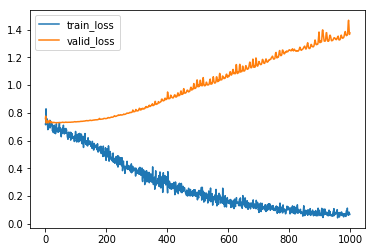

In [17]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_loss')
mplot.plot(validation_loss, label='valid_loss')
mplot.legend()
mplot.show()

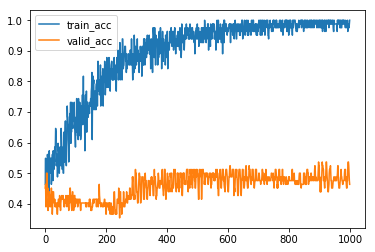

In [18]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc, label='train_acc')
mplot.plot(validation_acc, label='valid_acc')
mplot.legend()
mplot.show()

In [19]:
# test_acc = []

# with tf.Session() as sess:
#     # Restore
#     saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
#     for x_t, y_t in get_batches(X_test_norm, Y_test_onehot, batch_size):
#         feed = {inputs_: x_t,
#                 labels_: y_t,
#                 keep_prob_: 1}
        
#         batch_acc = sess.run(accuracy, feed_dict=feed)
#         test_acc.append(batch_acc)
#     print("Test accuracy: {:.6f}".format(np.mean(test_acc)))